# Naive Bayes

Naive Bayes is a common baseline technique for spam detection. Here, we explore how this method can be used to detect trolls solely from the text of a tweet. To do this, we will rely heavily on ideas developped by Tejan Karmali in an article on towardsdatascience.com<a href="#References">$^1$</a>. We downloaded and adapted the code he used to make his article, and put it in a module called `tejank.py`.

## Table of content
- <a href="#cleaning">Cleaning up the dataset</a>
- <a href="#cloud">Cloud exploration</a>
- <a href="#train">Training and testing the model</a>
- <a href="#References">References</a>

<div id="cleaning"></div>

## Cleaning up the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import tejank

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
troll_df = pd.read_csv("../data/troll_jun_to_nov_v2.csv", index_col="Unnamed: 0")
troll_df.head()

,Unnamed: 0.1,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,has_link
45,2161,1.504356e+09,GALLOWAYELIANA,"#CharlotteUprising protests at NFL game, cuts ...",United States,English,2016-10-05 13:48:00,10/5/2016 13:49,1000,1148,1799,RETWEET,left,0,1,LeftTroll,True
46,2162,1.504356e+09,GALLOWAYELIANA,Gotta stay high all my life to forget I'm miss...,United States,English,2016-10-05 13:48:00,10/5/2016 13:48,1000,1148,1798,RETWEET,left,0,1,LeftTroll,True
47,2163,1.504356e+09,GALLOWAYELIANA,How to send the perfect demo https://t.co/3dWa...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1803,RETWEET,left,0,1,LeftTroll,True
48,2164,1.504356e+09,GALLOWAYELIANA,Feeling superior hasn't caused an entire race ...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1801,RETWEET,left,0,1,LeftTroll,True
49,2165,1.504356e+09,GALLOWAYELIANA,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1802,RETWEET,left,0,1,LeftTroll,True


In [3]:
del troll_df["Unnamed: 0.1"]

The techniques that we'll use highly depend the language that we deal with, so we'll only keep English. By doing so we won't get rid of too many samples as most of the tweets we have in our dataset are in English:

In [4]:
troll_df.language.value_counts()

English               166252
French                   321
Spanish                  207
Vietnamese               188
Italian                  174
Dutch                    100
German                    97
Portuguese                80
Arabic                    72
Norwegian                 63
Romanian                  57
Estonian                  51
Swedish                   44
Albanian                  41
Farsi (Persian)           37
Japanese                  31
Croatian                  30
Catalan                   30
Uzbek                     28
Polish                    22
Lithuanian                22
LANGUAGE UNDEFINED        19
Hindi                     17
Icelandic                 16
Turkish                   13
Hungarian                 12
Kurdish                   11
Russian                   10
Somali                     9
Tagalog (Filipino)         9
Finnish                    9
Danish                     8
Bulgarian                  6
Czech                      6
Slovenian     

In [5]:
troll_df = troll_df[troll_df.language == 'English']

We manually add a label to say that these tweets are troll tweets.

In [6]:
troll_df["is_troll"] = 1

In [7]:
non_troll_df = pd.read_json("../data/non_troll_data_simplified_v4.json")
non_troll_df.head()

,index,created_at,id,is_quote_status,lang,possibly_sensitive,retweet_count,retweeted,scopes,source,text,truncated,withheld_in_countries,followers,following,is_a_retweet,has_link
0,603148,2016-11-08 16:58:18,796034121906745344,False,en,0.0,50924,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @HillaryClinton: Don't stand still. Vote to...,False,None,387,359,True,True
1,603149,2016-11-08 22:34:35,796118750059700224,False,es,0.0,229,False,None,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @Javierito321: Yo si gana Trump / Yo si gan...,False,None,685,949,True,True
10,603158,2016-11-09 03:40:03,796195620541243392,True,en,0.0,0,False,None,"<a href=""http://twitter.com/download/iphone"" r...",THANK GOD https://t.co/XKSWHg133c,False,None,131,33,False,True
100,603248,2016-11-09 02:28:06,796177513613402112,False,en,0.0,12809,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @J4CKMULL: Hillary Clinton really did the #...,False,None,338,315,True,True
1000,604148,2016-11-08 13:46:47,795985921342640128,True,en,NaN,1,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @OthewhomaniT: #ElectionDay\nRaise your han...,False,None,2245,1633,True,False


We manually put a label to say that these tweets are trolls.

In [8]:
non_troll_df["is_troll"] = 0

In [9]:
non_troll_df = non_troll_df.rename(columns={"text": "content"})

In [10]:
non_troll_df.shape[0]

1053747

In [11]:
non_troll_df.lang.value_counts()

en     962426
und     39316
es      27108
fr       6544
pt       2868
it       2427
de       2198
in       1332
tr       1015
nl        971
ar        931
tl        914
ja        910
ht        571
ca        444
th        395
pl        386
sv        382
ru        254
da        246
et        244
ro        234
hi        201
el        179
ko        136
no        135
cy        134
cs         97
fi         91
fa         85
vi         79
eu         72
zh         65
ur         58
lt         56
hu         46
lv         34
sl         33
iw         32
is         31
uk         20
ne         12
ta         10
bn          5
sr          5
ml          4
mr          3
te          2
si          2
am          2
bg          1
ka          1
Name: lang, dtype: int64

English seems to be way less dominant in this dataset than in the troll one, let's verify that the few dominant languages are correct.

In [12]:
non_troll_df[non_troll_df.lang == 'en'].sample(10).content

239714                  @realDonaldTrump 's sniff is a tell.
857348     He's looking at the menu and wondering if he c...
333364     RT @johnastoehr: Donald Trump appears in unear...
676563     Hillary Clinton was right.\n\n https://t.co/IC...
1006463    RT @nytopinion: Get excited: @FrankBruni will ...
693710     RT @sxdoc: #PodestaEmails9 Former Pageant Cont...
568518     Walk around Philly long enough w/ a map, a smi...
295582     RT @otepofficial: Another one! #DonTheCon #deb...
109061     yes, the difference between being an "outsider...
828967     The Trumps Just keep disgracing themselves and...
Name: content, dtype: object

`und` is used when the language was not automatically detected. These tweets generally only have hashtags or @ mentions. To make sure that we do not pick up non-english hashtags and @ mentions, we'll get rid of this category.

In [13]:
non_troll_df[non_troll_df.lang == 'und'].sample(10).content

603015    RT @DanScavino: #MakeAmericaSafeAgain🇺🇸\n#RNCi...
785513    RT @tyleroakley: #ImWithHer https://t.co/m5Xx5...
770401    #KaineWreck #VPDebate @HillaryClinton https://...
545310             @realDonaldTrump https://t.co/bYTqhU4RiF
285130    RT @HillaryClinton: #DebateNight https://t.co/...
186290    RT @BigHeadSports: #DemsInPhilly https://t.co/...
897733              @HillaryClinton https://t.co/VUXjsIVrvO
585291    RT @TexasRebelAR15: #LockHerUp #LockHerUp #Loc...
983962             @realDonaldTrump https://t.co/XtxZ9PVVcW
689599               @BuzzFeedNews  https://t.co/Zz43rBjzbs
Name: content, dtype: object

In [14]:
non_troll_df[non_troll_df.lang == 'es'].sample(10).content

377452    4. Clinton y los frentes abiertos https://t.co...
516631    Cómo se nota que el señor Trump se aburre con ...
6245      Creo que es buen momento para abrir una empres...
27576     RT @bea_veintiuno: Parece que en EEUU y España...
12829     Este es el momento en que Donald Trump @realDo...
226894    RT @HistoriaEnFotos: El #debatenight #debates2...
936846    Las claves y los problemas de Apple con la lle...
813220    RT @24h_tve: Los republicanos mantienen el con...
911987    @HillaryClinton lo malo es que yo soñé que est...
479491    RT @SBerensztein: Muchos observadores señalan ...
Name: content, dtype: object

In [15]:
non_troll_df[non_troll_df.lang == 'fr'].sample(10).content

269322    RT @gblardone: Le mec a eu la patience d'écout...
676214    RT @lauhaim: Michelle Obama fera campagne  ven...
152813    RT @DemConvention: "Our revolution continues."...
852256    RT @Dbargen: The debate souvenir. Ben Garrison...
706634    RT @lauhaim: Intéressant d écouter le message ...
34946     J'habite pas aux États Unis mais ça me stress ...
47873     pour l'instant... #ElectionDay #Clinton en têt...
286512    RT @Bic__Rouge: *J'ouvre Twitter pour suivre l...
735578       Je suis Robert De Niro https://t.co/eoqSanWI3K
429035        RT @mishcavoy: PRENEZ TRUMP RENDEZ-NOUS GLENN
Name: content, dtype: object

Languages seem to be correct, we'll only keep English once again.

In [16]:
non_troll_df = non_troll_df[non_troll_df.lang == 'en']

Now let's make the classes even.

In [17]:
print("There are {} observations in the troll dataset.".format(troll_df.shape[0]))
print("There are {} observatins in the non-troll dataset.".format(non_troll_df.shape[0]))

There are 166252 observations in the troll dataset.
There are 962426 observatins in the non-troll dataset.


We will randomly downsample the non-troll dataset to have the same number of tweets in each category.

In [18]:
non_troll_df_undersampled = non_troll_df.sample(n=troll_df.shape[0], random_state=123)

In [19]:
print("There are {} observations in the troll dataset.".format(troll_df.shape[0]))
print("There are {} observatins in the non-troll undersampled dataset.".format(non_troll_df_undersampled.shape[0]))

There are 166252 observations in the troll dataset.
There are 166252 observatins in the non-troll undersampled dataset.


In [20]:
full_df = pd.concat((troll_df[["content", "is_troll"]],
                     non_troll_df_undersampled[["content", "is_troll"]]))

In [21]:
full_df.is_troll.value_counts()

1    166252
0    166252
Name: is_troll, dtype: int64

In [22]:
full_df.head()

,content,is_troll
45,"#CharlotteUprising protests at NFL game, cuts ...",1
46,Gotta stay high all my life to forget I'm miss...,1
47,How to send the perfect demo https://t.co/3dWa...,1
48,Feeling superior hasn't caused an entire race ...,1
49,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,1


Let's clean up the indexes of the full dataset.

In [23]:
full_df.reset_index(drop=True, inplace=True)

In [24]:
full_df.head()

,content,is_troll
0,"#CharlotteUprising protests at NFL game, cuts ...",1
1,Gotta stay high all my life to forget I'm miss...,1
2,How to send the perfect demo https://t.co/3dWa...,1
3,Feeling superior hasn't caused an entire race ...,1
4,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,1


<div id="cloud"></div>

## Cloud exploration

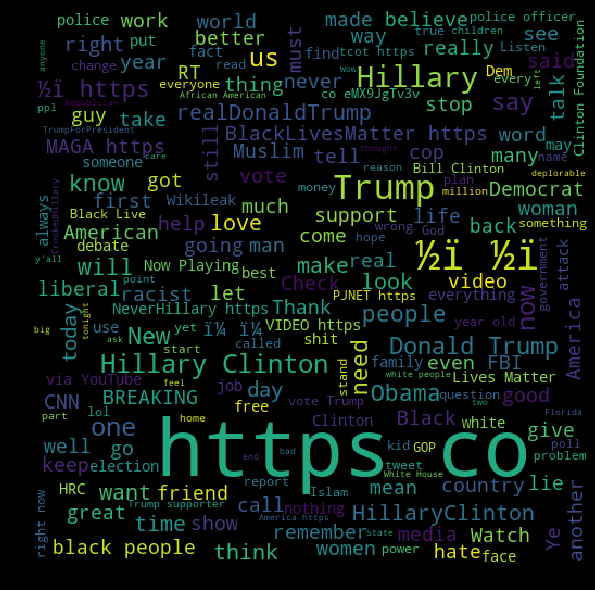

Wall time: 11 s


In [26]:
%%time
tejank.create_word_cloud(full_df, is_troll_label=1)

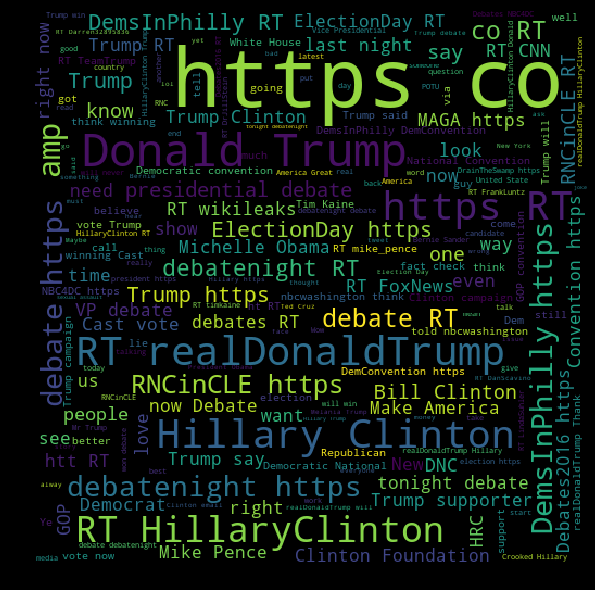

Wall time: 10.4 s


In [27]:
%%time
tejank.create_word_cloud(full_df, is_troll_label=0)

These word clouds reveal at least two things on the differences of the two datasets:
 - Racial-related tweets seem to be way more present in troll tweets than in non-troll tweets: "Black", "White", "African American", "BlackLivesMatter", "black people" are easily noticeable in the troll cloud whereas they seem completely absent of the non-troll cloud.
 - The non-troll tweets seem much more factual, generally mentioning big events (e.g. Debate Night, Election Day) or candidates (e.g. Donald Trump, Hillary Clinon). On the contrary, many more touchy subjects seem to be discussed in the troll tweets (cf "police", "women", "Muslim", "Islam", "racist", etc)

Let's see if we can have more insight on what these troll tweets say on these touchy subjects.

In [36]:
def show_tweets_about(dataframe, subject, max_num=10):
    for i, tweet in enumerate(dataframe.content[dataframe.content.apply(lambda x: subject in x)][:max_num], 1):
        print(i, tweet)

In [40]:
touchy_subjects = ["police", "women", "Muslim", "Islam", "racist"]

In [41]:
for subject in touchy_subjects:
    print("##### Subject: {}".format(subject))
    show_tweets_about(troll_df, subject)
    print("\n")

##### Subject: police
1 LRT: The Chicago police ARE a criminal gang.
2 Newark police killed two black teenagers this past Saturday  https://t.co/hR4fj5VGOj https://t.co/7H2z6EZeoB
3 You'll hear police asking for "respect",men demanding "respect", because demanding submission and obedience reveals the means of domination
4 4-6 armed men have stormed a police training center in #Quetta, #Pakistan & 200 cadets hostages ï¿½ https://t.co/XAAYrvbSzX via @metesohtaoglu
5 Social justice warriors have vowed to call the police on people wearing âoffensiveâ Halloween costumes. Yes, really. https://t.co/odrRcouV7S
6 Twice now CNN has deceptively edited video to present a particular narrative of police shootings â>  https://t.co/1H6OQT98Yx
7 2 police officers shot in San Diego and all #BlackLivesMatter members keep silent Don't their lifes matter? https://t.co/2QjpLSPpQG
8 The police worried about "gang" violence when they are the only "gang" being violent
9 Suspect in Boston police shooting 

What about the non-troll tweets?

In [45]:
for subject in touchy_subjects:
    print("##### Subject: {}".format(subject))
    show_tweets_about(non_troll_df, subject)
    print("\n")

##### Subject: police
1 RT @Bernlennials: The silence continues as native communities face police violence for protecting their water #debatenight #NoDAPL https://…
2 RT @samswey: Here's what the candidates have proposed to address police violence. https://t.co/xCQdHOCjrv #debatenight https://t.co/nBj33n6…
3 i hope both candidates talk about REAL issues like police brutality, syria, palestine, etc instead of arguing #debatenight
4 I'm still dissapointed of the silence of #blacklivesmatter, militarization of police, murder of innocent blacks at the last #debate(in STL)!
5 A podium debate about to start and the audience already looks like it needs riot police. America 2016. #debate2016
6 RT @EchoingIda: #Debates2016: We don't feel protected by police! @JScruggs0601 for @Rewire_News: https://t.co/ELeqdJ3eZx
7 RT @4lisaguerrero: Women, especially those that have to report sexual assault to the police, need to look at this and let it sink in. https…
8 RT @ellabakercenter: To transform the j

Let's focus on non-retweets:

In [46]:
for subject in touchy_subjects:
    print("##### Subject: {}".format(subject))
    show_tweets_about(non_troll_df[non_troll_df.is_a_retweet == False], subject)
    print("\n")

##### Subject: police
1 i hope both candidates talk about REAL issues like police brutality, syria, palestine, etc instead of arguing #debatenight
2 I'm still dissapointed of the silence of #blacklivesmatter, militarization of police, murder of innocent blacks at the last #debate(in STL)!
3 A podium debate about to start and the audience already looks like it needs riot police. America 2016. #debate2016
4 @realDonaldTrump #deportationforce sounds more like a police state.
5 @realDonaldTrump #4 Restore law and order while creating prosperity in inner cities. No more scapegoating police for 8 yrs of Dem failure
6 Bottom line-She thinks we are world police vs Trump thinks we should focus on protecting our country and stopping d… https://t.co/PQl79VGHYK
7 Is this the best Country in the World ?
#USA #Clinton #Trump #Obama #police 
https://t.co/L0SOJxEFhm
8 Beastie Boys - #Sabotage https://t.co/tmd1GEaDV2 #music #debates2016 #cspan #msnbc #abc #cbs #cnn #fox #democrat #gop #policestate #nwo

<div id="train"></div>

## Training and testing the model

In [102]:
train_df, test_df = train_test_split(full_df, test_size=.2, random_state=123)

In [96]:
from sklearn.metrics import accuracy_score

In [123]:
subsample = 2000
train_df_subsampled = train_df.sample(subsample)
test_df_subsampled = test_df.sample(subsample)
train_df_subsampled.is_troll.value_counts()
test_df_subsampled.is_troll.value_counts()

0    1013
1     987
Name: is_troll, dtype: int64

In [124]:
%%time
sc_bow = TrollClassifier(train_df_subsampled, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test_df_subsampled['content'])
preds_bow_train = sc_bow.predict(train_df_subsampled['content'])
print("Train accuracy is {}".format(accuracy_score(train_df_subsampled['is_troll'], list(preds_bow_train.values()))))
print("Test accuracy is {}".format(accuracy_score(test_df_subsampled['is_troll'], list(preds_bow.values()))))

Train accuracy is 0.993
Test accuracy is 0.596
Wall time: 22.1 s


In [125]:
%%time
sc_bow = TrollClassifier(train_df_subsampled, 'tf-idf')
sc_bow.train()
preds_bow = sc_bow.predict(test_df_subsampled['content'])
preds_bow_train = sc_bow.predict(train_df_subsampled['content'])
print("Train accuracy is {}".format(accuracy_score(train_df_subsampled['is_troll'], list(preds_bow_train.values()))))
print("Test accuracy is {}".format(accuracy_score(test_df_subsampled['is_troll'], list(preds_bow.values()))))

Train accuracy is 0.993
Test accuracy is 0.591
Wall time: 21.9 s


# References

[1] Tejan Karmali, *Spam Classifier in Python from scratch*, https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73